In [2]:
# !pip install comet-ml

In [3]:
# !pip install shap

# Imports

In [4]:
# Import before anyone else

# import comet_ml
# from comet_ml import Experiment

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shap


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

# Load Data

In [5]:
df = pd.read_csv(r'/kaggle/input/nhltidydata/tidy_df_new.csv', index_col = None)
print(df.columns)
# df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)



Index(['Unnamed: 0', 'game_id', 'season', 'season_type', 'event_id',
       'home_team', 'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'distance_from_net',
       'attacking_team_side', 'angle_from_net'],
      dtype='object')


# New Added Features (Q4)

In [6]:
import pandas as pd
import numpy as np
import math
import os

# data = "tidy_df.csv"
data = df

def get_df(data):
#     df = pd.read_csv(data)
    df = data
    return df

def get_new_features():
    df = get_df(data)
    df['game_seconds'] = df['period_time']
    df1 = df['game_seconds'].str.split(':',expand=True).astype(int)
    df['game_seconds'] = df1[0]*60+df1[1]
    df['game_seconds'] = ((df['period']-1)*(60*20) + df['game_seconds'])
    df['previous_event_game_seconds'] = df['previous_event_period_time']
    df2 = df['previous_event_game_seconds'].str.split(':',expand=True).astype(int)
    df['previous_event_game_seconds'] = df2[0]*60+df2[1]
    df['previous_event_game_seconds'] = ((df['previous_event_period']-1)*(60*20) + df['previous_event_game_seconds'])
    df['time_since_last_event'] = df['game_seconds']-df['previous_event_game_seconds']
    df['distance_from_last_event'] = np.sqrt((df['x_coordinates']**2 - df['previous_event_x_coordinates'])**2 + (df['y_coordinates'] - df['previous_event_y_coordinates'])**2)
    df['distance_from_last_event'] = df['distance_from_last_event'].round(decimals=2)
    df['distance_from_net'] = df['distance_from_net'].round(decimals=2)
    rebound = np.empty(len(df.index),dtype=bool)
    for index, row in df.iterrows():
        if row['previous_event_type']=='Shot':
            rebound[index]=True
        else:
            rebound[index]=False
    df['rebound'] = rebound.tolist()
    df['speed'] = (df['distance_from_last_event']/df['time_since_last_event']).round(decimals=2)
    
    return df

def get_angle_change():
    df = get_df(data)
    list_angle = []
    for index, row in df.iterrows():
        if row['previous_event_type']=='Shot':
            if df.attacking_team_side[index] == "right":
                if df.previous_event_y_coordinates[index] == 0:
                    list_angle.append(np.absolute(df.angle_from_net[index]))
                else:
                    distance_from_net = np.sqrt(df.previous_event_y_coordinates[index]**2+df.previous_event_x_coordinates[index]**2)
                    angle = np.arcsin(df.previous_event_y_coordinates[index]/distance_from_net)*-180/math.pi
                    sign = np.sign([angle,df.angle_from_net[index]])
                    change_in_angle = 0
                    if sign[0]!=sign[1]:
                        change_in_angle = np.absolute(angle) + np.absolute(df.angle_from_net[index])
                    else:
                        change_in_angle = np.absolute(angle-df.angle_from_net[index])
                    list_angle.append(change_in_angle)
                    
            if df.attacking_team_side[index] == "left":
                if df.previous_event_y_coordinates[index] == 0:
                    list_angle.append(np.absolute(df.angle_from_net[index]))
                else:
                    distance_from_net = np.sqrt(df.previous_event_y_coordinates[index]**2+df.previous_event_x_coordinates[index]**2)
                    angle = np.arcsin(df.previous_event_y_coordinates[index]/distance_from_net)*180/math.pi
                    sign = np.sign([angle,df.angle_from_net[index]])
                    change_in_angle = 0
                    if sign[0]!=sign[1]:
                        change_in_angle = np.absolute(angle) + np.absolute(df.angle_from_net[index])
                    else:
                        change_in_angle = np.absolute(angle-df.angle_from_net[index])
                    list_angle.append(change_in_angle)  
        else:
            list_angle.append(0)
            
       
    df['change_in_angle'] = list_angle
    df['change_in_angle'] = df['change_in_angle'].round(decimals=2)
    
    return df

In [7]:
df = get_new_features()
df = get_angle_change()

In [8]:
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.columns

Index(['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'distance_from_net',
       'attacking_team_side', 'angle_from_net', 'game_seconds',
       'previous_event_game_seconds', 'time_since_last_event',
       'distance_from_last_event', 'rebound', 'speed', 'change_in_angle'],
      dtype='object')

In [9]:
old_feat = ['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'distance_from_net',
       'attacking_team_side', 'angle_from_net']

df_feat = df.columns.tolist()

# features extracted in question 4
new_feat = [feat for feat in df_feat if feat not in old_feat]
print(len(old_feat),len(df_feat),len(new_feat) )

28 35 7


# Data Split

In [10]:
df_train = df[df['season'] != 20192020]
df_test = df[df['season'] == 20192020]

## 5.1 Train-test

In [11]:
X_1 = df_train[['angle_from_net', 'distance_from_net']]
y_1 = df_train['goal_ind']
#y = y.astype(int)
# (#BLOG)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1,y_1,test_size=0.15,random_state=10, stratify=y_1, shuffle = True)

## 5.2 Train-test

In [12]:
X_2 = df_train[new_feat]
y_2 = df_train['goal_ind']
#y = y.astype(int)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2,y_2,test_size=0.15,random_state=10, stratify=y_2, shuffle = True)

In [13]:
print(X_train_1.shape)
print(X_train_2.shape)

(282812, 2)
(282812, 7)


In [14]:
df_train["goal_ind"].value_counts()

0    301638
1     31083
Name: goal_ind, dtype: int64

# cometml

In [15]:
# experiment = Experiment(api_key = "Pvo648g2gS8jvAP6ZVdt45H5A", project_name = "milestone-2", workspace="kleitoun")

# XGBoost Classifier

## 5.1

## Experiment url: https://www.comet.ml/kleitoun/milestone-2/6244c288bec04ab28ba6c2c030708813?experiment-tab=metrics

In [16]:
model_1 = XGBClassifier()
 
# fit the model with the training data
model_1.fit(X_train_1,y_train_1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:40:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
preds_1 = model_1.predict(X_valid_1)

In [18]:
X_train_1.isnull().sum()
np.isinf(X_train_1).values.sum()

0

In [19]:
explainer = shap.Explainer(model_1)
shap_values = explainer(X_train_1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


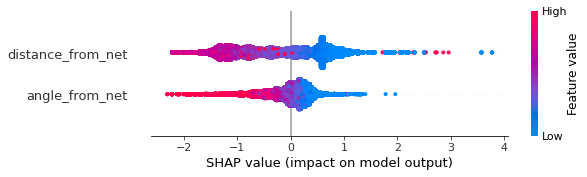

In [20]:
shap.summary_plot(shap_values, X_train_1)

### Evaluation - XGBoost Baseline (5.1)

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [22]:
y_pred_proba_1 = model_1.predict_proba(X_valid_1)[:,1]
roc_auc =  roc_auc_score(y_valid_1,y_pred_proba_1)
y_pred_1 = model_1.predict(X_valid_1)
accuracy =  accuracy_score(y_valid_1, y_pred_1)
report = classification_report(y_valid_1, y_pred_1, output_dict=True)


In [23]:
print(roc_auc, accuracy)
report

0.7177188559381944 0.9065899937886954


{'0': {'precision': 0.9067348165965123,
  'recall': 0.9998010873889405,
  'f1-score': 0.9509964682139254,
  'support': 45246},
 '1': {'precision': 0.5263157894736842,
  'recall': 0.002144542140253056,
  'f1-score': 0.004271678769756514,
  'support': 4663},
 'accuracy': 0.9065899937886954,
 'macro avg': {'precision': 0.7165253030350982,
  'recall': 0.5009728147645968,
  'f1-score': 0.47763407349184095,
  'support': 49909},
 'weighted avg': {'precision': 0.8711922506570274,
  'recall': 0.9065899937886954,
  'f1-score': 0.8625439307321454,
  'support': 49909}}

In [24]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [25]:
# experiment.log_metrics(metrics)

In [26]:
params = {"base_score":0.5, "booster":"gbtree", "colsample_bylevel":1,
              "colsample_bynode":1, "colsample_bytree":1, "enable_categorical":False,
              "gamma":0, "gpu_id":1, "importance_type":None,
              "learning_rate":0.300000012,
              "max_delta_step":0, "max_depth":6, "min_child_weight":1, "missing":np.nan,
              "monotone_constraints":'()', "n_estimators":100, "n_jobs":2,
              "num_parallel_tree":1, "predictor":'auto', "random_state":0,
              "reg_alpha":0, "reg_lambda":1, "scale_pos_weight":1, "subsample":1,
              "tree_method":'exact', "validate_parameters":1, "verbosity":None}

In [27]:
# experiment.log_parameters(params)

In [28]:
def infer_model(X_valid,y_valid,model):
    global y_pred
    global predicted_prob

    y_pred = model.predict(X_valid)
    predicted_prob = model.predict_proba(X_valid)

    return y_valid, y_pred, X_valid.shape, predicted_prob


In [29]:
# plot_model = model_1


# df_train2 = X_train_1.copy()
# # df_train2['angle_from_net_abs'] = df_train2['angle_from_net'].abs() #Absolute angle considered for training the model
# df_train2['Random_Baseline'] = 0
# fpr,tpr,roc_auc = dict(),dict(),dict()
# fpr_list,tpr_list,roc_auc_list,feature_list=[],[],[],[]
# df_cum_prop1,df_cum_prop2,df_cum_prop3 = [],[],[]

# df_perc,goal_count,shot_count,goal_rate,cum_goal_rate,pctile,pctile_prop = [],[],[],[],[],[],[]
# goal_count2,pctile2,cum_goal_rate2 = [],[],[]
# n_bins, quant = 40,2.5
# list_model_iter = [['distance_from_net'],
#                    ['angle_from_net_abs'],
#                    ['distance_from_net','angle_from_net_abs'],
#                    ['Random_Baseline'],
#                   ]
# # y = df_train2['goal_ind']
# predicted_prob_goal,temp_y_valid = [],[]

# for ele in list_model_iter:
#     feature_list.append(ele)
    
#     if ele != ['Random_Baseline']:
#         if df_train2[ele].shape[1] == 1:
#             X_valid_1 = X_valid_1[ele].values.reshape(-1,1)
#             infer_model(X_valid_1,y_valid_1,plot_model)
#             temp_y_valid += y_valid_1.tolist()
#             for prob in predicted_prob:
#                 predicted_prob_goal.append(prob[1])
#         else:
# #             X = df_train2[ele].values
#             infer_model(X_valid_1,y_valid_1,plot_model)
#             temp_y_valid  += y_valid_1.tolist()
#             for prob in predicted_prob:
#                 predicted_prob_goal.append(prob[1])

#     else:
#         X = df_train2['distance_from_net'].values.reshape(-1,1)
#         call_log_reg(X_valid_1,y_valid_1,plot_model)
#         temp_y_valid  += y_valid_1.tolist()
#         for ele in range(X_valid_1.shape[0]):
#             predicted_prob_goal.append(np.random.uniform(0, 1)) 
# #            temp_y_valid.append(np.random.randint(0, 1)) #<------------check this

# #--------------------Determine ROC curve----------------------------------
# length = len(temp_y_valid)/4
# df_prob = pd.DataFrame(list(zip(temp_y_valid,predicted_prob_goal)), columns = ['goal_ind','Goal_Prob'])
# df_prob['shot_count'] = 1

# # df_calib is copy of df_prob
# df_calib = df_prob.copy()
# for m in range(len(list_model_iter)):
#     df_prob_f = df_prob.loc[m*length:length*(m+1)-1,:]
#     fpr, tpr, _ = roc_curve(df_prob_f['goal_ind'], df_prob_f['Goal_Prob'])
#     roc_auc = auc(fpr, tpr)
#     fpr_list.append(fpr)
#     tpr_list.append(tpr)
#     roc_auc_list.append(roc_auc)
# # df_prob_f1 is copy of df_prob_f
#     df_prob_f1 = df_prob_f.copy()
#     df_prob_f1['percentile'] = df_prob_f1['Goal_Prob'].rank(pct=True)
#     quantile_list = np.linspace(0,1,n_bins*5+1).round(4).tolist()
#     q = df_prob_f1.quantile(quantile_list)
#     col = 'Goal_Prob'
#     for i in np.arange(quant,(quant*n_bins)+1,quant):
#         df_perc = df_prob_f1[((df_prob_f1[col]>=q[col][(i-quant)/100]) & (df_prob_f1[col]<q[col][i/100]))]
#         goal_count.append(df_perc['goal_ind'].sum())
#         shot_count.append(df_perc['shot_count'].sum())
#         goal_rate.append(df_perc['goal_ind'].sum()/df_perc['shot_count'].sum())
#         pctile.append(i)
#     df_perc_prop = pd.DataFrame(list(zip(goal_count,shot_count,goal_rate,pctile)),columns=['goal_count',"sum_shot_count",'goal_rate','pctile'])
# # df_prob_f2 is copy of df_prob_f

#     df_prob_f2 = df_prob_f.copy()
#     df_prob_f2['percentile'] = df_prob_f2['Goal_Prob'].rank(pct=True)
#     q2 = df_prob_f2.quantile(quantile_list)
#     total = df_prob_f2['goal_ind'].sum()

#     temp,j=0,100
    
#     for j in np.arange((quant*n_bins),0,-quant):
#         df_perc2 = df_prob_f2[((df_prob_f2[col]>q[col][(j-quant)/100]) & (df_prob_f2[col]<=q[col][j/100]))]
#         goal_count2.append(df_perc2.goal_ind.sum())
#         temp+=df_perc2.goal_ind.sum()
#         cum_goal_rate2.append(temp/total)
#         pctile2.append(j)
       
#     df_perc_prop_cum = pd.DataFrame(list(zip(goal_count2,cum_goal_rate2,pctile2)),columns=['goal_count','cum_goal_rate','pctile'])
# #print(df_perc_prop_cum[:20])

# # Call for functions to plot curves
# #----------------------------------------------------------------------------------------------- 
# df_roc=pd.DataFrame(list(zip(fpr_list,tpr_list)),columns = ['FPR','TPR'])
# df_auc=pd.DataFrame(list(zip(feature_list,roc_auc_list)),columns = ['Feature','AUC'])
# roc_auc_plot(df_roc,df_auc)
# #--------------------Determine Goal Rate (#goals / (#no_goals + #goals)) ----------------------------------
# goal_rate_plot(df_perc_prop,n_bins)

# #-----------------------------------------------------------------------------------------------
# cum_rate_plot(df_perc_prop_cum,n_bins)
# #------------------------------------------

In [30]:
# experiment.end

## 5.2

In [31]:
X_train_2.isnull().sum()

game_seconds                      0
previous_event_game_seconds       0
time_since_last_event             0
distance_from_last_event       4358
rebound                           0
speed                          4358
change_in_angle                   3
dtype: int64

In [32]:
# X_train_2.isinf().sum()
for f in ["distance_from_last_event", "speed", "change_in_angle"]:
    print(np.isinf(X_train_2[[f]]).values.sum())
np.isinf(y_train_2).values.sum()

0
5058
0


0

In [33]:
X_train_2.replace([np.inf, -np.inf], np.nan, inplace=True)
for f in ["distance_from_last_event", "speed", "change_in_angle"]:
    print(np.isinf(X_train_2[[f]]).values.sum())

0
0
0



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
print(X_train_2.isnull().sum())

game_seconds                      0
previous_event_game_seconds       0
time_since_last_event             0
distance_from_last_event       4358
rebound                           0
speed                          9416
change_in_angle                   3
dtype: int64


In [35]:
X_train_2.fillna(0, inplace=True)
print(X_train_2.isnull().sum())

game_seconds                   0
previous_event_game_seconds    0
time_since_last_event          0
distance_from_last_event       0
rebound                        0
speed                          0
change_in_angle                0
dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
model_2 = XGBClassifier()
 
# fit the model with the training data
model_2.fit(X_train_2,y_train_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:42:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
preds_2 = model_2.predict(X_valid_2)

### Performance Plots

In [38]:
# # Functions for 4 plots

# def roc_auc_plot(df_roc,df_auc):
#     plt.figure(figsize=(12.5,7.5))
#     lw = 3
#     color_list = ['darkorange','green','navy','red']
#     for i in range(4):
        
#         plt.plot(df_roc.FPR[i], df_roc.TPR[i],color=color_list[i],lw=lw,label=f'{df_auc.Feature[i]} (area = {df_auc.AUC[i]})')

#     plt.plot([0, 1], [0, 1], color="black", lw=lw, label="Ideal Random Baseline",linestyle="--")
#     plt.legend(fontsize=12)
#     plt.ylabel('True Positive Rate', fontsize=18)
#     plt.xlabel('False Positive Rate', fontsize=18)
#     plt.title("ROC CURVE", fontsize=18)
#     plt.savefig('ROC.png')
#     plt.show()

# def goal_rate_plot(df_perc_prop,n_bins):
    
#     fig = plt.figure(figsize=(12.5,7.5))
#     color_list = ['darkorange','green','navy','red']
    
#     for i in range(4):

#         ax = sns.lineplot(x = df_perc_prop.pctile[i*n_bins:n_bins*(i+1)-1], y = df_perc_prop.goal_rate[i*n_bins:n_bins*(i+1)-1], label=f'{df_auc.Feature[i]}', color=color_list[i], legend = False, linewidth = 3)

#     ax.set_xlim(left=105, right=-5)
#     ax.set_ylim(bottom=0, top=df_perc_prop['goal_rate'].max()+0.05)
#     fig.legend(loc="upper right")
#     plt.title(f"Goal Rate v.s. Shot Probability Model Percentile")
#     fig.legend(loc="upper right")
#     #plt.autoscale()
#     fig.show()
#     plt.savefig('Goal_Rate.png')

# def cum_rate_plot(df_perc_prop_cum,n_bins):
    
#     fig = plt.figure(figsize=(12.5,7.5))
#     color_list = ['darkorange','green','navy','red']
    
#     for i in range(4):

#         ax = sns.lineplot(x = df_perc_prop_cum.pctile[i*n_bins:n_bins*(i+1)-1], y = df_perc_prop_cum.cum_goal_rate[i*n_bins:n_bins*(i+1)-1], label=f'{df_auc.Feature[i]}', color=color_list[i], legend = False, linewidth = 3)
 
#     ax.set_xlim(left=105, right=-5)
#     ax.set_ylim(bottom=0, top=df_perc_prop_cum['cum_goal_rate'].max()+0.05)
#     fig.legend(loc="upper right")
#     plt.title(f"Cumulative Goal Rate v.s. Shot Probability Model Percentile")
#     plt.grid(color='r', linestyle='-', linewidth=0.25)
#     fig.legend(loc="upper right")
#     #plt.autoscale()
#     fig.show()
#     plt.savefig('Cum_Goal.png')

# def calibration_plot(df_calib,n_bins,length):
#     fig = plt.figure(figsize=(10, 10))
#     ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1)
#     ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     for i in range(4):
#         prob_true, prob_pred = calibration_curve(df_calib.goal_ind[int(i*length):int(length*(i+1)-1)], df_calib.Goal_Prob[int(i*length):int(length*(i+1)-1)], n_bins=n_bins)
#         ax1.plot(prob_pred, prob_true, "s-",label=f'{df_auc.Feature[i]}')
#     ax1.set_ylabel("Fraction of positives")
#     ax1.set_ylim([-0.05, 1.05])
#     ax1.legend(loc="lower right")
#     ax1.set_title('Calibration plots  (reliability curve)')
#     ax1.set_xlabel("Mean predicted value")
#     ax1.set_ylabel("Fraction of Positives")
#     ax1.legend(loc="upper center", ncol=2)
#     plt.tight_layout()
#     plt.savefig('Calibration_Curve.png')


In [39]:
df_train.angle_from_net.describe()

count    332721.000000
mean         29.909764
std          20.431608
min           0.000000
25%          13.570434
50%          27.758541
75%          42.273689
max          90.000000
Name: angle_from_net, dtype: float64

# Hyper-paramter Tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [41]:
# A parameter grid for XGBoost
params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.3, 0.2, 0.1],
    'max_depth': [4,6 , 7, 8]
}

In [42]:
y_train_2.shape

(282812,)

In [43]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model_2, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=1001 )

# Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_2,y_train_2)
# timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  7.2min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:49:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6eceed2c50>,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1...
                                           n_estimators=100, n_jobs=2,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=0,
          

In [44]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([127.50166512,  57.50388392,  85.27062138, 125.3002406 ,
       121.12648368]), 'std_fit_time': array([ 2.94577878,  3.63370714,  1.14737827,  1.23058379, 29.48020907]), 'mean_score_time': array([1.39912478, 0.78369252, 1.15425603, 1.3367552 , 0.80376816]), 'std_score_time': array([0.15759981, 0.02020143, 0.12065085, 0.0756965 , 0.31641492]), 'param_n_estimators': masked_array(data=[100, 100, 100, 150, 150],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[8, 4, 6, 6, 8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.2, 0.2, 0.1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}, {'n_estimators': 100, 'max_depth': 4, 'l

In [45]:
model_2_hmtuned = XGBClassifier(n_estimators= 150, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)
 
# fit the model with the training data
model_2_hmtuned.fit(X_train_2,y_train_2)

[19:49:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [46]:
y_pred_proba_2 = model_2.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)



In [47]:
print(roc_auc, accuracy)

0.6810668339263553 0.9065899937886954


### Evaluation - XGBoost post Hyperparameter Tuning

In [48]:
y_pred_proba_2 = model_2_hmtuned.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2_hmtuned.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)




In [49]:
print(roc_auc, accuracy)

0.7056900130929592 0.9065699573223266


In [50]:
# count examples in each class
counter = Counter(y_pred_2)
print(counter[0] , counter[1])

49905 4


# To avoid heavy class imbalance problem, tuning class weights scale

In [51]:
# NOTE: this approach does NOT yield any good results (#BLOG)

weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

In [52]:
# NOTE: this approach does NOT yield any good results


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search
# grid = GridSearchCV(estimator=model_2_hmtuned, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# # execute the grid search
# grid_result = grid.fit(X_train_2,y_train_2)

grid_result = RandomizedSearchCV(model_2, param_distributions=param_grid, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=1001 )

grid_result.fit(X_train_2,y_train_2)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  5.4min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:55:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.698693 using {'scale_pos_weight': 1}
0.676255 (0.000262) with: {'scale_pos_weight': 100}
0.687718 (0.000856) with: {'scale_pos_weight': 25}
0.677411 (0.000581) with: {'scale_pos_weight': 75}
0.698693 (0.000728) with: {'scale_pos_weight': 1}
0.681831 (0.001479) with: {'scale_pos_weight': 50}


In [53]:
# NOTE: this approach does NOT yield any good results


scale_pos_weight = 9
model_2_cw = XGBClassifier(n_estimators= 150, scale_pos_weight = scale_pos_weight, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)
 
# fit the model with the training data
model_2_cw.fit(X_train_2,y_train_2)

[19:56:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=9,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [54]:
# NOTE: this approach does NOT yield any good results


y_pred_proba_cw = model_2_cw.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = model_2_cw.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)


In [55]:
print(roc_auc, accuracy)
report

0.7018531235763898 0.6442926125548498


{'0': {'precision': 0.9455193647707016,
  'recall': 0.6447862794501171,
  'f1-score': 0.7667179143506656,
  'support': 45246},
 '1': {'precision': 0.1565025716385011,
  'recall': 0.6395024662234613,
  'f1-score': 0.25146519374288484,
  'support': 4663},
 'accuracy': 0.6442926125548498,
 'macro avg': {'precision': 0.5510109682046014,
  'recall': 0.6421443728367893,
  'f1-score': 0.5090915540467752,
  'support': 49909},
 'weighted avg': {'precision': 0.8718014921149592,
  'recall': 0.6442926125548498,
  'f1-score': 0.7185778306744934,
  'support': 49909}}

In [56]:
from collections import Counter

# count examples in each class
counter = Counter(y_pred_cw)
print(counter[0] , counter[1])
# estimate scale_pos_weight value
# estimate = counter[0] / counter[1]
# print('Estimate: %.3f' % estimate)

30855 19054


### Class weights

In [57]:
from sklearn.utils import class_weight

# assigining class weight to balanced does NOT yield any good results/makes NO difference (#BLOG)

classes_weights = class_weight.compute_sample_weight(
    # this took manual tuning
    class_weight={0:0.18, 1:0.82},
    y=y_train_2
)

In [58]:
model_2_cw = XGBClassifier(n_estimators= 150, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)

model_2_cw.fit(X_train_2, y_train_2, sample_weight=classes_weights)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:56:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [59]:
y_pred_cw = model_2_cw.predict(X_valid_2)


In [60]:
from collections import Counter
# count examples in each class
counter = Counter(y_pred_cw)
print(counter[0] , counter[1])

45164 4745


In [61]:
y_valid_2.value_counts()

0    45246
1     4663
Name: goal_ind, dtype: int64

### Evaluation - XGBoost post Class Weights (5.2)

In [62]:
y_pred_proba_cw = model_2_cw.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = model_2_cw.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)

print(roc_auc, accuracy)
report



0.7050266274250434 0.8600252459476246


{'0': {'precision': 0.9235674430962714,
  'recall': 0.9218936480572868,
  'f1-score': 0.9227297865280388,
  'support': 45246},
 '1': {'precision': 0.25521601685985246,
  'recall': 0.25970405318464507,
  'f1-score': 0.25744047619047616,
  'support': 4663},
 'accuracy': 0.8600252459476246,
 'macro avg': {'precision': 0.5893917299780619,
  'recall': 0.5907988506209659,
  'f1-score': 0.5900851313592574,
  'support': 49909},
 'weighted avg': {'precision': 0.8611233408193188,
  'recall': 0.8600252459476246,
  'f1-score': 0.8605717778702004,
  'support': 49909}}

# Feature Selection (5.3)

In [63]:
y_valid_1.nunique()

2

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


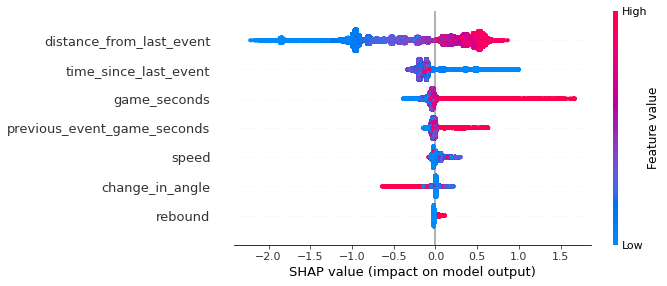

In [64]:
## To also visualize the importance of class weight and stratifying the data, 
# the difference between the feature importance graphs could be helpful(#BLOG)

explainer_2 = shap.Explainer(model_2_cw)
shap_values_2 = explainer_2(X_train_2)

shap.summary_plot(shap_values_2, X_train_2)

### Applying Recursive Feature Elimination

In [65]:
#adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# from numpy import sort
from sklearn.feature_selection import SelectFromModel
#
thresholds = np.sort(model_2_cw.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
    select_X_train_2 = selection.transform(X_train_2)
    # train model
    selection_model = XGBClassifier(n_estimators= 150, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)
    selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)
    # eval model
    select_X_valid_2 = selection.transform(X_valid_2)
    y_pred = selection_model.predict(select_X_valid_2)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid_2, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train_2.shape[1], accuracy*100.0))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:57:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.024, n=7, Accuracy: 86.00%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:57:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.047, n=6, Accuracy: 85.92%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.049, n=5, Accuracy: 85.38%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:58:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.081, n=4, Accuracy: 85.18%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:58:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.170, n=3, Accuracy: 85.28%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:58:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.310, n=2, Accuracy: 85.65%
[19:58:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Thresh=0.320, n=1, Accuracy: 88.81%


#### Thresh = 0.320 with 1 feature yields best accuracy, but this can result being highly biased towards the majority class, so we stick with n=7

In [66]:
model_2_cw.feature_importances_

array([0.08129495, 0.16964746, 0.31953448, 0.309717  , 0.02373662,
       0.04941827, 0.04665128], dtype=float32)

In [67]:
selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
select_X_train_2 = selection.transform(X_train_2)
    # train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)
    # eval model

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:58:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Experiment Tracking

In [68]:
# import comet_ml
# import os

# # Check to see if there is a key in environment:
# EXPERIMENT_KEY = os.environ.get("COMET_EXPERIMENT_KEY", None)

# # First, let's see if we continue or start fresh:
# CONTINUE_RUN = False
# if (EXPERIMENT_KEY is not None):
#     # There is one, but the experiment might not exist yet:
#     api = comet_ml.API() # Assumes API key is set in config/env
#     try:
#         api_experiment = api.get_experiment_by_id(EXPERIMENT_KEY)
#     except Exception:
#         api_experiment = None
#     if api_experiment is not None:
#         CONTINUE_RUN = True
#         # We can get the last details logged here, if logged:
#         step = int(api_experiment.get_parameters_summary("steps")["valueCurrent"])
#         epoch = int(api_experiment.get_parameters_summary("epochs")["valueCurrent"])

# if CONTINUE_RUN:
#     # 1. Recreate the state of ML system before creating experiment
#     # otherwise it could try to log params, graph, etc. again
#     # ...
#     # 2. Setup the existing experiment to carry on:
#     experiment = comet_ml.ExistingExperiment(
#         previous_experiment=EXPERIMENT_KEY,
#         log_env_details=True, # to continue env logging
#         log_env_gpu=True,     # to continue GPU logging
#         log_env_cpu=True,     # to continue CPU logging
#     )
#     # Retrieved from above APIExperiment
#     experiment.set_step(step)
#     experiment.set_epoch(epoch)

# else:
#     # 1. Create the experiment first
#     #    This will use the COMET_EXPERIMENT_KEY if defined in env.
#     #    Otherwise, you could manually set it here. If you don't
#     #    set COMET_EXPERIMENT_KEY, the experiment will get a
#     #    random key!
#     experiment = comet_ml.Experiment()
#     # 2. Setup the state of the ML system